In [186]:
from DepressionModel import DepressionModel
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

In [187]:
G = nx.Graph()

phq_values = np.arange(0, 28)
# Assign probabilities: most weight to 5–14
probs = np.array([0.02]*5 + [0.08]*10 + [0.01]*13)  # sums to 1
probs = probs / probs.sum()

# Sample
phq_scores = np.random.choice(phq_values, size=10, p=probs)
for i, phq in enumerate(phq_scores):
    G.add_node(i, phq9=phq)

edges = [
    (0, 1, 0.8),
    (1, 2, 0.6),
    (2, 3, 0.5),
    (3, 4, 0.9),
    (4, 5, 0.7),
    (5, 6, 0.3),
    (6, 7, 0.4),
    (7, 8, 1.0),
    (8, 9, 0.6),
    (9, 0, 0.5),
    (1, 7, 0.2),
    (3, 8, 0.3)
]

for u, v, w in edges:
    G.add_edge(u, v, weight=w)

# Assign co-rumination scores
def assign_pancrs_scores(G):
    for i in G.nodes:
        G.nodes[i]['crt_pos_total'] = np.round(np.random.normal(3.8, 0.4), 2)   # total positive
        G.nodes[i]['crt_neg_total'] = np.round(np.random.normal(2.8, 0.5), 2)   # total negative
        G.nodes[i]['crt_freq_pos']  = np.round(np.random.normal(3.1, 0.6), 2)   # freq positive
        G.nodes[i]['crt_freq_neg']  = np.round(np.random.normal(2.6, 0.7), 2)   # freq negative

assign_pancrs_scores(G)




In [188]:
def classify_phq9(phq9):
    if phq9 <= 4:
        return 0  # Healthy
    elif phq9 <= 14:
        return 1  # Mild
    else:
        return 2  # Depressed

for i in G.nodes:
    phq = G.nodes[i]['phq9']
    G.nodes[i]['d_state_ego'] = classify_phq9(phq)


In [189]:
depression_class = DepressionModel(G)
depression_class.simulate(400)

state_history = depression_class.its['states']

100%|██████████| 400/400 [00:00<00:00, 4181.24it/s]


# Transmission model

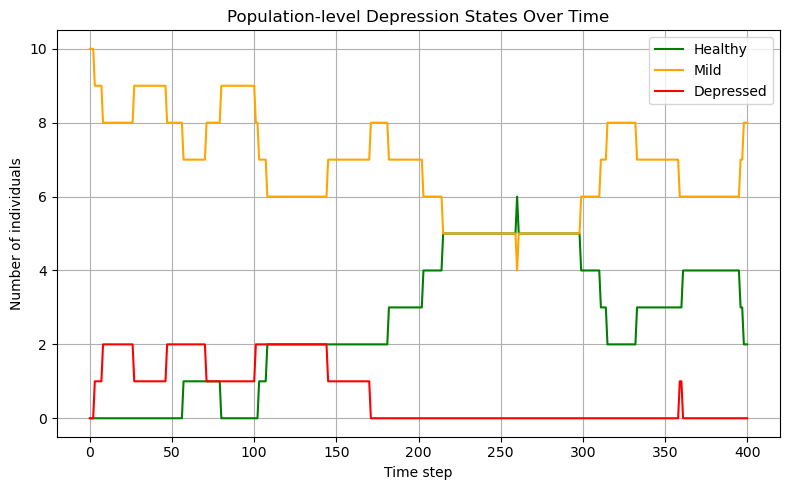

In [190]:
timesteps = sorted(state_history.keys())
n_steps = len(timesteps)

# Initialize counters
H = []
M = []
D = []

# Count how many nodes are in each state at every time step
for t in timesteps:
    state = state_history[t]
    H.append(np.count_nonzero(state == 0))
    M.append(np.count_nonzero(state == 1))
    D.append(np.count_nonzero(state == 2))

# Plot
plt.figure(figsize=(8, 5))
plt.plot(H, label="Healthy", color="green")
plt.plot(M, label="Mild", color="orange")
plt.plot(D, label="Depressed", color="red")
plt.xlabel("Time step")
plt.ylabel("Number of individuals")
plt.title("Population-level Depression States Over Time")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Majority Voter model with bounded confidence

In [ ]:
CONFIDENCE_THRESHOLD = 0.8  # only update from neighbors with edge weight ≥ this
CONVERGENCE_RATE = 0.5    # how much a node adjusts toward neighbor average
NUM_ITERATIONS = 12         # total number of update steps
W_BROOD = 1.0   # how strongly brooding increases susceptibility
W_REFLECT = 1.0 # how strongly reflection buffers influence


def bounded_confidence_update(G, threshold=0.5, mu=0.5, steps=50, brooding_weight=0.5, reflecting_weight=0.5):
    history = []
    node_order = list(sorted(G.nodes()))
    scores = np.array([G.nodes[i]['phq9'] for i in node_order], dtype=float)

    for _ in range(steps):
        new_scores = scores.copy()
        
        for idx, i in enumerate(node_order):
            neighbors = G[i]
            relevant_scores = []

            for j in neighbors:
                w = G[i][j].get('weight')
                
                if w >= threshold:
                    j_idx = node_order.index(j)
                    relevant_scores.append(scores[j_idx])

            if relevant_scores:
                neighbor_mean = np.mean(relevant_scores)

                #modify susceptibility based on co-rumination scores
                crt_neg = G.nodes[i].get('crt_neg_total')
                freq_neg = G.nodes[i].get('crt_freq_neg')
                crt_pos = G.nodes[i].get('crt_pos_total')
                freq_pos = G.nodes[i].get('crt_freq_pos')

                brooding_component = brooding_weight * (crt_neg + freq_neg) / 10.0
                reflection_component = reflecting_weight * (crt_pos + freq_pos) / 10.0

                processing_bias = np.clip(brooding_component - reflection_component, -1, 1)
                mu_i = mu * processing_bias
                new_scores[idx] = scores[idx] + mu_i * (neighbor_mean - scores[idx])
                new_scores[idx] = np.clip(new_scores[idx], 0, 27) #should be in range
        
        scores = new_scores
        history.append(scores.copy())

    return np.array(history), node_order

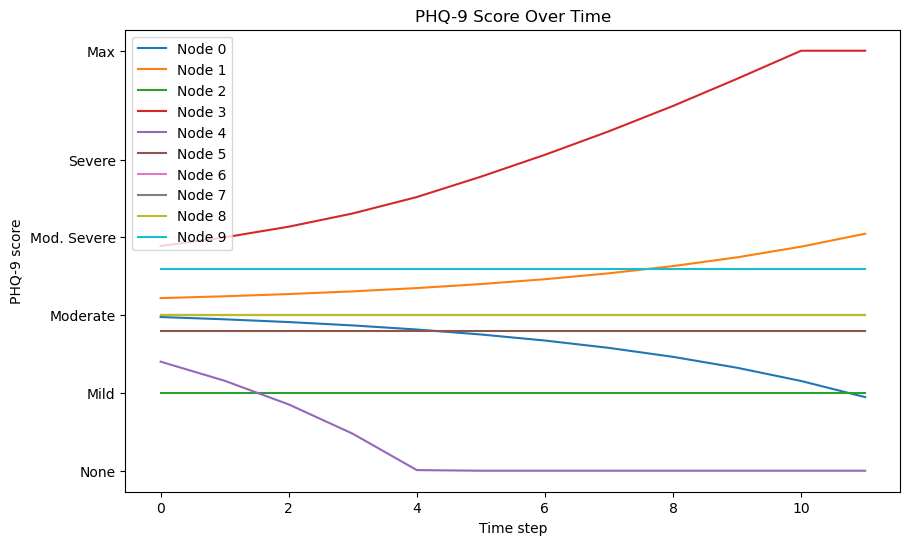

In [192]:
history, nodes = bounded_confidence_update(G, 
                                           threshold=CONFIDENCE_THRESHOLD,
                                           mu=CONVERGENCE_RATE,
                                           steps=NUM_ITERATIONS,
                                           brooding_weight=W_BROOD,
                                           reflecting_weight=W_REFLECT)

plt.figure(figsize=(10, 6))
for i, node in enumerate(nodes):
    plt.plot(history[:, i], label=f'Node {node}')  # use actual node label
plt.xlabel("Time step")
plt.ylabel("PHQ-9 score")
plt.yticks([0, 5, 10, 15, 20, 27],
           labels=["None", "Mild", "Moderate", "Mod. Severe", "Severe", "Max"])
plt.title("PHQ-9 Score Over Time")
plt.legend()
plt.show()

# Probabilistic bounded confidence

In [193]:
CONFIDENCE_THRESHOLD = 0.8  # only update from neighbors with edge weight ≥ this
CONVERGENCE_RATE = 0.8  # how much a node adjusts toward neighbor average
NUM_ITERATIONS = 12        # total number of update steps
W_BROOD = 1.0   # how strongly brooding increases susceptibility
W_REFLECT = 1.0 # how strongly reflection buffers influence


def probabilistic_bounded_confidence_update(G, threshold=0.5, mu=0.5, steps=50, brooding_weight=0.5, reflecting_weight=0.5):
    history = []
    node_order = list(sorted(G.nodes()))
    scores = np.array([G.nodes[i]['phq9'] for i in node_order], dtype=float)

    for _ in range(steps):
        new_scores = scores.copy()
        
        for idx, i in enumerate(node_order):
            neighbors = G[i]
            relevant_scores = []

            for j in neighbors:
                w = G[i][j].get('weight')
                
                if w >= threshold:
                    j_idx = node_order.index(j)
                    relevant_scores.append(scores[j_idx])

            if relevant_scores:
                neighbor_mean = np.mean(relevant_scores)

                #modify susceptibility based on co-rumination scores
                crt_neg = G.nodes[i].get('crt_neg_total')
                freq_neg = G.nodes[i].get('crt_freq_neg')
                crt_pos = G.nodes[i].get('crt_pos_total')
                freq_pos = G.nodes[i].get('crt_freq_pos')

                brooding_component = brooding_weight * (crt_neg + freq_neg) / 10.0
                reflection_component = reflecting_weight * (crt_pos + freq_pos) / 10.0

                # Compute probability of updating based on net brooding vs reflection
                raw_trait_score = (crt_neg + freq_neg) - (crt_pos + freq_pos)
                prob_update = np.clip((raw_trait_score + 8) / 16.0, 0, 1)  # Linear mapping to [0, 1]

                if np.random.rand() < prob_update:
                    processing_bias = np.clip(raw_trait_score / 10.0, -1, 1)
                    mu_i = mu * processing_bias
                    new_scores[idx] = scores[idx] + mu_i * (neighbor_mean - scores[idx])
                    new_scores[idx] = np.clip(new_scores[idx], 0, 27) #should be in range
                # else: do nothing, score remains unchanged
        
        scores = new_scores
        history.append(scores.copy())

    return np.array(history), node_order

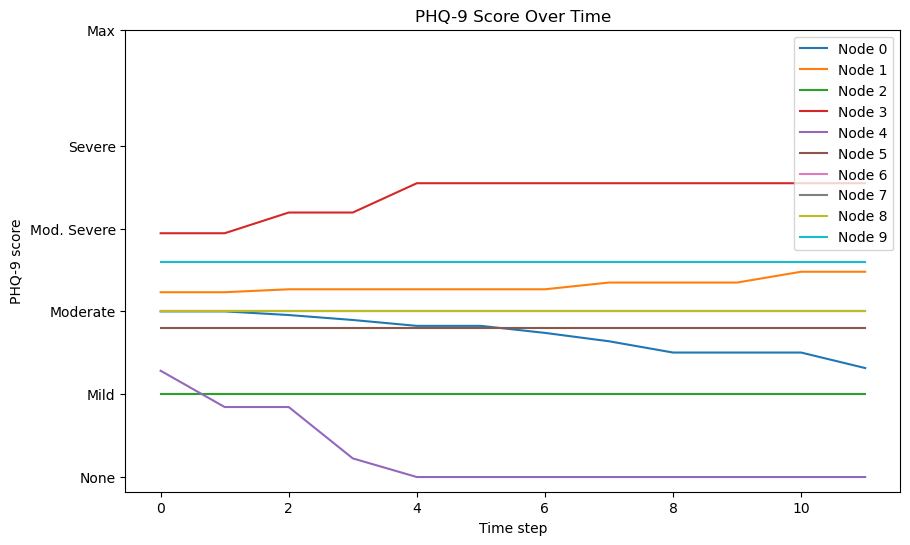

In [194]:
history, nodes = probabilistic_bounded_confidence_update(G, 
                                           threshold=CONFIDENCE_THRESHOLD,
                                           mu=CONVERGENCE_RATE,
                                           steps=NUM_ITERATIONS,
                                           brooding_weight=W_BROOD,
                                           reflecting_weight=W_REFLECT)

plt.figure(figsize=(10, 6))
for i, node in enumerate(nodes):
    plt.plot(history[:, i], label=f'Node {node}')  # use actual node label
plt.xlabel("Time step")
plt.ylabel("PHQ-9 score")
plt.yticks([0, 5, 10, 15, 20, 27],
           labels=["None", "Mild", "Moderate", "Mod. Severe", "Severe", "Max"])
plt.title("PHQ-9 Score Over Time")
plt.legend()
plt.show()

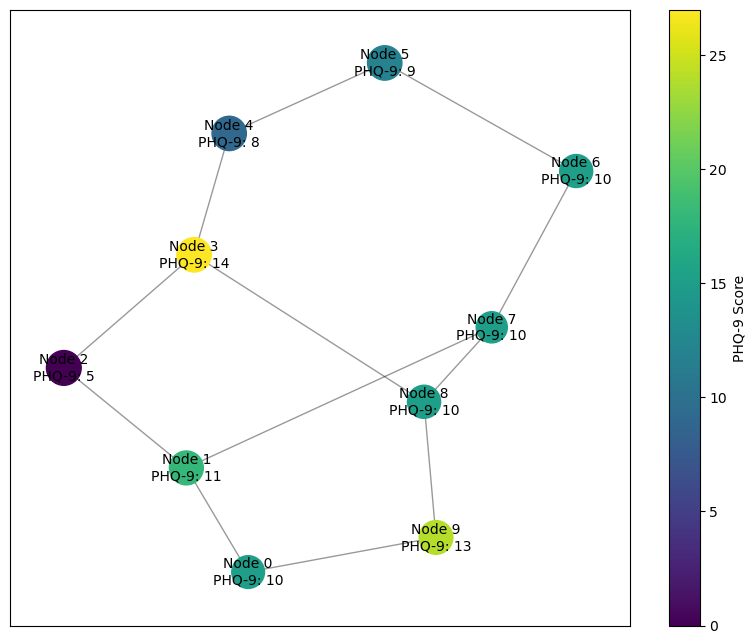

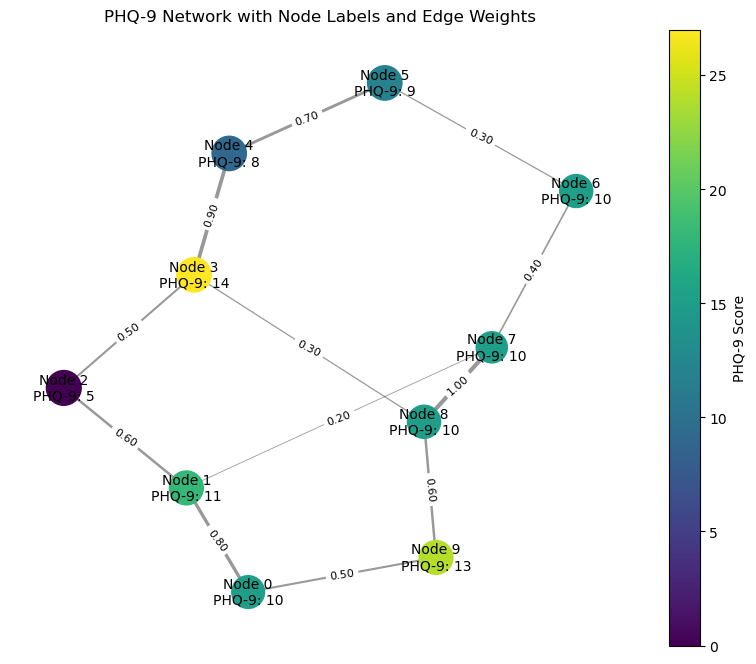

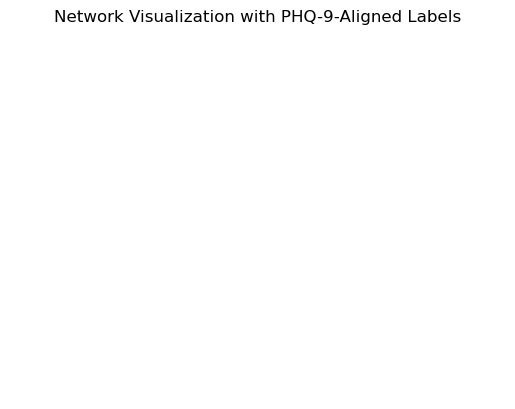

In [ ]:
pos = nx.spring_layout(G, seed=42)

# Use sorted order to align with time series
node_order = list(sorted(G.nodes()))
node_colors = [G.nodes[n]['phq9'] for n in node_order]
node_sizes = [300 + 100 * G.nodes[n]['crt_neg_total'] for n in node_order]

# 🔧 Extract edge weights for line width
edge_weights = [G[u][v]['weight'] for u, v in G.edges()]

plt.figure(figsize=(10, 8))

# Draw edges with thickness proportional to weight
nx.draw_networkx_edges(G, pos, width=[3*w for w in edge_weights], alpha=0.4)

# Draw nodes
nx.draw_networkx_nodes(
    G, pos,
    nodelist=node_order,
    node_color=node_colors,
    cmap='viridis',
    node_size=node_sizes
)

# Matching node labels
node_labels = {
    n: f"Node {n}\nPHQ-9: {G.nodes[n]['phq9']}" for n in node_order
}
nx.draw_networkx_labels(G, pos, labels=node_labels, font_size=10)

# Optional: show edge weight labels too
edge_labels = {(u, v): f"{G[u][v]['weight']:.2f}" for u, v in G.edges()}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8)

# Colorbar for PHQ-9
sm = plt.cm.ScalarMappable(cmap='viridis', norm=plt.Normalize(vmin=0, vmax=27))
sm.set_array([])
plt.colorbar(sm, label="PHQ-9 Score")

plt.title("PHQ-9 Network with Node Labels and Edge Weights")
plt.axis('off')
plt.show()
